**AIM**

To perform image classification using DenseNet as a feature extractor, leveraging its pretrained capabilities to extract deep features and classify input images efficiently.

**OBJECTIVES**

To understand the structure and function of DenseNet (Densely Connected Convolutional Networks).

To load and preprocess a labeled image dataset for classification.

To use a pretrained DenseNet model (e.g., DenseNet121) to extract features.

To build a custom classifier on top of the extracted features.

To train, evaluate, and test the classification pipeline.

To save and visualize results including model performance.



**THEORY**

DenseNet, short for Densely Connected Convolutional Network, is a deep CNN architecture that introduces direct connections between any two layers with the same feature-map size. Each layer receives inputs from all preceding layers and passes on its own feature maps to all subsequent layers, enhancing feature propagation and reducing redundancy.

**Key Features of DenseNet:**

Dense Connections: Improves gradient flow, making optimization easier and more accurate.

Parameter Efficiency: Due to feature reuse, DenseNet requires fewer parameters than traditional CNNs.

Deep Supervision: Earlier layers receive more direct supervision from the loss function due to shortcut connections.

**Steps Involved in Feature Extraction using DenseNet:**

Load the Pretrained DenseNet Model (e.g., DenseNet121) with include_top=False.

Freeze the Base Layers to retain learned features.

Add Custom Dense Layers to perform classification on your specific dataset.

Compile, Train, and Evaluate the final model.

In [ ]:
!pip install -q tensorflow scikit-learn matplotlib

In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize using ImageNet statistics
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Loaded CIFAR-10 dataset with training samples:", len(train_dataset))
print("Loaded CIFAR-10 dataset with testing samples:", len(test_dataset))

100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


Loaded CIFAR-10 dataset with training samples: 50000
Loaded CIFAR-10 dataset with testing samples: 10000


In [ ]:
# Load DenseNet121 pretrained on ImageNet
model = models.densenet121(pretrained=True)

model.classifier = nn.Identity()
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 157MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def extract_features(dataloader):
    features_list = []
    labels_list = []
    # We disable gradients for feature extraction
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Forward pass
            outputs = model(inputs)
            # Move outputs to CPU and convert to NumPy arrays
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())
    features = np.concatenate(features_list)
    labels   = np.concatenate(labels_list)
    return features, labels

print("Extracting features from training data...")
train_features, train_labels = extract_features(train_loader)
print("Extracting features from test data...")
test_features, test_labels = extract_features(test_loader)

print("Shape of training features:", train_features.shape)
print("Shape of test features:", test_features.shape)

Extracting features from training data...
Extracting features from test data...
Shape of training features: (50000, 1024)
Shape of test features: (10000, 1024)


In [ ]:
clf = LogisticRegression(max_iter=1000)
print("Training logistic regression classifier on extracted features...")
clf.fit(train_features, train_labels)

Training logistic regression classifier on extracted features...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
print("Evaluating the classifier...")
predictions = clf.predict(test_features)
acc = accuracy_score(test_labels, predictions)
print(f"Test Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(test_labels, predictions))

Evaluating the classifier...
Test Accuracy: 89.47%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1000
           1       0.95      0.94      0.94      1000
           2       0.90      0.86      0.88      1000
           3       0.80      0.80      0.80      1000
           4       0.86      0.87      0.87      1000
           5       0.87      0.85      0.86      1000
           6       0.91      0.94      0.92      1000
           7       0.92      0.91      0.92      1000
           8       0.92      0.94      0.93      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



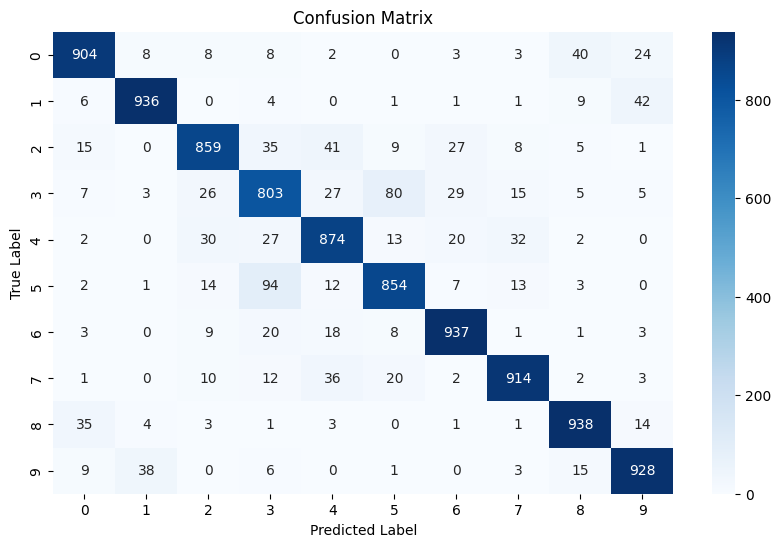

In [ ]:
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Conclusion**

Using DenseNet as a feature extractor offers a highly effective approach for solving image classification problems. The model leverages deep pretrained feature representations, allowing for:

Faster convergence during training

High classification accuracy, even on limited datasets

Reduced training costs and complexity

This approach is a powerful application of transfer learning and is widely used in industrial and research settings for tasks such as object detection, medical imaging, and fine-grained classification.

